# Heart Disease

In [1]:
import pandas as pd
import ehrapy as ep
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Installed version 0.2.0 of ehrapy is newer than the latest release 0.1.0! You are running a 
nightly version and features may break!

In [2]:
pd.set_option("display.max_columns", None)

## Getting the dataset

In [5]:
!wget -nc http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
!wget -nc http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data
!wget -nc http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data
!wget -nc http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data

File ‘processed.cleveland.data’ already there; not retrieving.

File ‘processed.switzerland.data’ already there; not retrieving.

File ‘reprocessed.hungarian.data’ already there; not retrieving.

File ‘processed.va.data’ already there; not retrieving.



In [6]:
!wget -nc http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleveland.data
!wget -nc http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/switzerland.data
!wget -nc http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/hungarian.data
!wget -nc http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/long-beach-va.data

!wget -nc http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names

File ‘cleveland.data’ already there; not retrieving.

--2022-04-24 21:53:18--  http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/switzerland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24674 (24K) [application/x-httpd-php]
Saving to: ‘switzerland.data’

switzerland.data    100%[===================>]  24,10K   152KB/s    in 0,2s    

2022-04-24 21:53:20 (152 KB/s) - ‘switzerland.data’ saved [24674/24674]

File ‘hungarian.data’ already there; not retrieving.

File ‘long-beach-va.data’ already there; not retrieving.

File ‘heart-disease.names’ already there; not retrieving.



# Data Wrangling

## Processed Dataset

In [7]:
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

In [8]:
file_names = ["processed.cleveland.data", "processed.switzerland.data", "reprocessed.hungarian.data", "processed.va.data"]

In [9]:
for file_name in file_names:
    if file_name == "reprocessed.hungarian.data":
        data = pd.read_csv(file_name, sep=" ", names=names)
    else:
        data = pd.read_csv(file_name, sep=",", names=names)
    # Replace the "?" in attributes with NaA, and then convert it to integer.
    data.dropna(how="all", inplace=True)
    for i in data.columns:
        if any(data[i]=='?'):
            data[i].replace('?', np.NaN, inplace=True)
            data[i] = pd.to_numeric(data[i])
        data[i].replace(-9, np.NaN, inplace=True)
    # Since the dataset does not have a patient ID we add one.
    data["patient_id"] = range(1, len(data) + 1)
    data.set_index("patient_id", inplace=True)
    output_file_name = file_name[:-5] + ".prepared.csv"
    data.to_csv(output_file_name)

In [10]:
prepared_file_names = [file_name[:-5] + ".prepared.csv" for file_name in file_names]

In [11]:
prepared_file_names

['processed.cleveland.prepared.csv',
 'processed.switzerland.prepared.csv',
 'reprocessed.hungarian.prepared.csv',
 'processed.va.prepared.csv']

In [12]:
processed_heart_disease = pd.concat((pd.read_csv(f).assign(
    dataset_name=f.split('.')[1]) for f in prepared_file_names))
processed_heart_disease.drop(["patient_id"], axis=1, inplace=True)
processed_heart_disease["patient_id"] = range(1, len(processed_heart_disease) + 1)
processed_heart_disease.set_index("patient_id", inplace=True)
processed_heart_disease.to_csv("processed_heart_disease.csv")

In [13]:
processed_heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 920 entries, 1 to 920
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           920 non-null    float64
 1   sex           920 non-null    float64
 2   cp            920 non-null    float64
 3   trestbps      861 non-null    float64
 4   chol          890 non-null    float64
 5   fbs           830 non-null    float64
 6   restecg       918 non-null    float64
 7   thalach       865 non-null    float64
 8   exang         865 non-null    float64
 9   oldpeak       858 non-null    float64
 10  slope         611 non-null    float64
 11  ca            310 non-null    float64
 12  thal          434 non-null    float64
 13  num           920 non-null    float64
 14  dataset_name  920 non-null    object 
dtypes: float64(14), object(1)
memory usage: 115.0+ KB


## ehrapy sanity check

In [14]:
adata = ep.io.read_csv("processed_heart_disease.csv",
                   index_column="patient_id")

In [15]:
adata = ep.pp.encode(adata, autodetect=True)

Running label encoding on column exang ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0%

In [18]:
ep.ad.type_overview(adata)

Variable names for AnnData object with 920 obs and 15 vars
╠══ 🔐 Encoded variables
║   ╠══ sex -> 2 categories; label encoded; original data type: string
║   ╠══ fbs -> 3 categories; label encoded; original data type: string
║   ╠══ exang -> 3 categories; label encoded; original data type: string
║   ╚══ dataset_name -> 4 categories; label encoded; original data type: string
╚══ 🔓 Unencoded variables
    ╠══ age -> data type: floating
    ╠══ cp -> data type: floating
    ╠══ trestbps -> data type: floating
    ╠══ chol -> data type: floating
    ╠══ restecg -> data type: floating
    ╠══ thalach -> data type: floating
    ╠══ oldpeak -> data type: floating
    ╠══ slope -> data type: floating
    ╠══ ca -> data type: floating
    ╠══ thal -> data type: floating
    ╚══ num -> data type: floating

Running KNN imputation ⠙

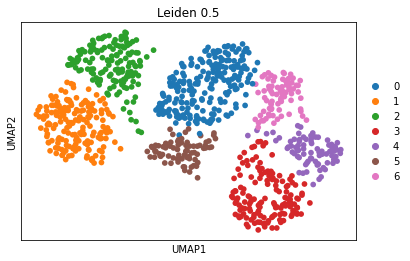

In [16]:
ep.pp.knn_impute(adata)
ep.pp.norm_scale(adata)
ep.pp.pca(adata)
ep.pp.neighbors(adata)
ep.tl.umap(adata)
ep.tl.leiden(adata, resolution=0.5, key_added="leiden_0_5")
ep.pl.umap(adata, color=["leiden_0_5"], title="Leiden 0.5")

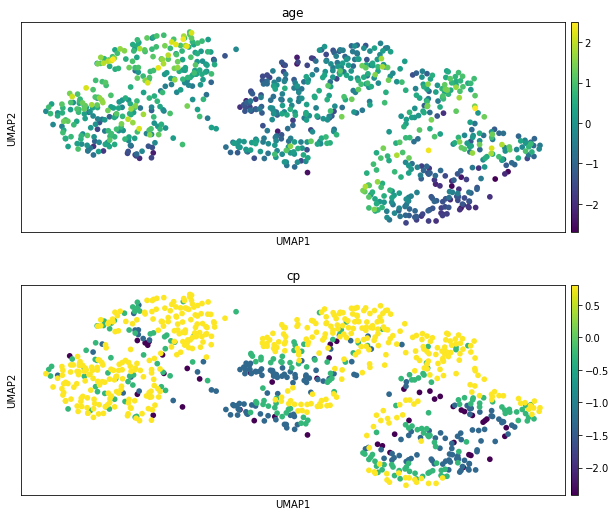

In [17]:
ep.pl.umap(adata, color=["age", "cp"], ncols=1, wspace=0.75)